['SigmanBiscoe_Science', 'Doyle_JACS', 'SigmanToste_JACS', 'List_ACIE_THF', 'List_ACIE_THP', 'HongAckermann_NatSyn', 'SigmanToste_Science_Allsamples', 'Sunoj_PNAS', 'Sunoj_JPC', 'Denmark_OPRD', 'Denmark_Science']
Worse than baseline: SigmanBiscoe_Science_LassoCV-descriptors_ee_withoutT.csv with MAE: 2.2877425010841175 and RMSE: 3.1737101818793936
SigmanBiscoe_Science_LassoCV-descriptors_ee_withoutT.csv with MAE: 2.2877425010841175 and RMSE: 3.1737101818793936
SigmanBiscoe_Science_KernelRidge_rbf_CV-descriptors_ee_withoutT.csv with MAE: 0.9621150073987151 and RMSE: 1.330832393915003
Worse than baseline: SigmanBiscoe_Science_LinearRegression-descriptors_ee_withoutT.csv with MAE: 3.9774079503615827 and RMSE: 5.886194963422913
SigmanBiscoe_Science_LinearRegression-descriptors_ee_withoutT.csv with MAE: 3.9774079503615827 and RMSE: 5.886194963422913
Worse than baseline: SigmanBiscoe_Science_GaussianProcess_CV-descriptors_ee_withoutT.csv with MAE: 1.8547450772305707 and RMSE: 2.56360744556413

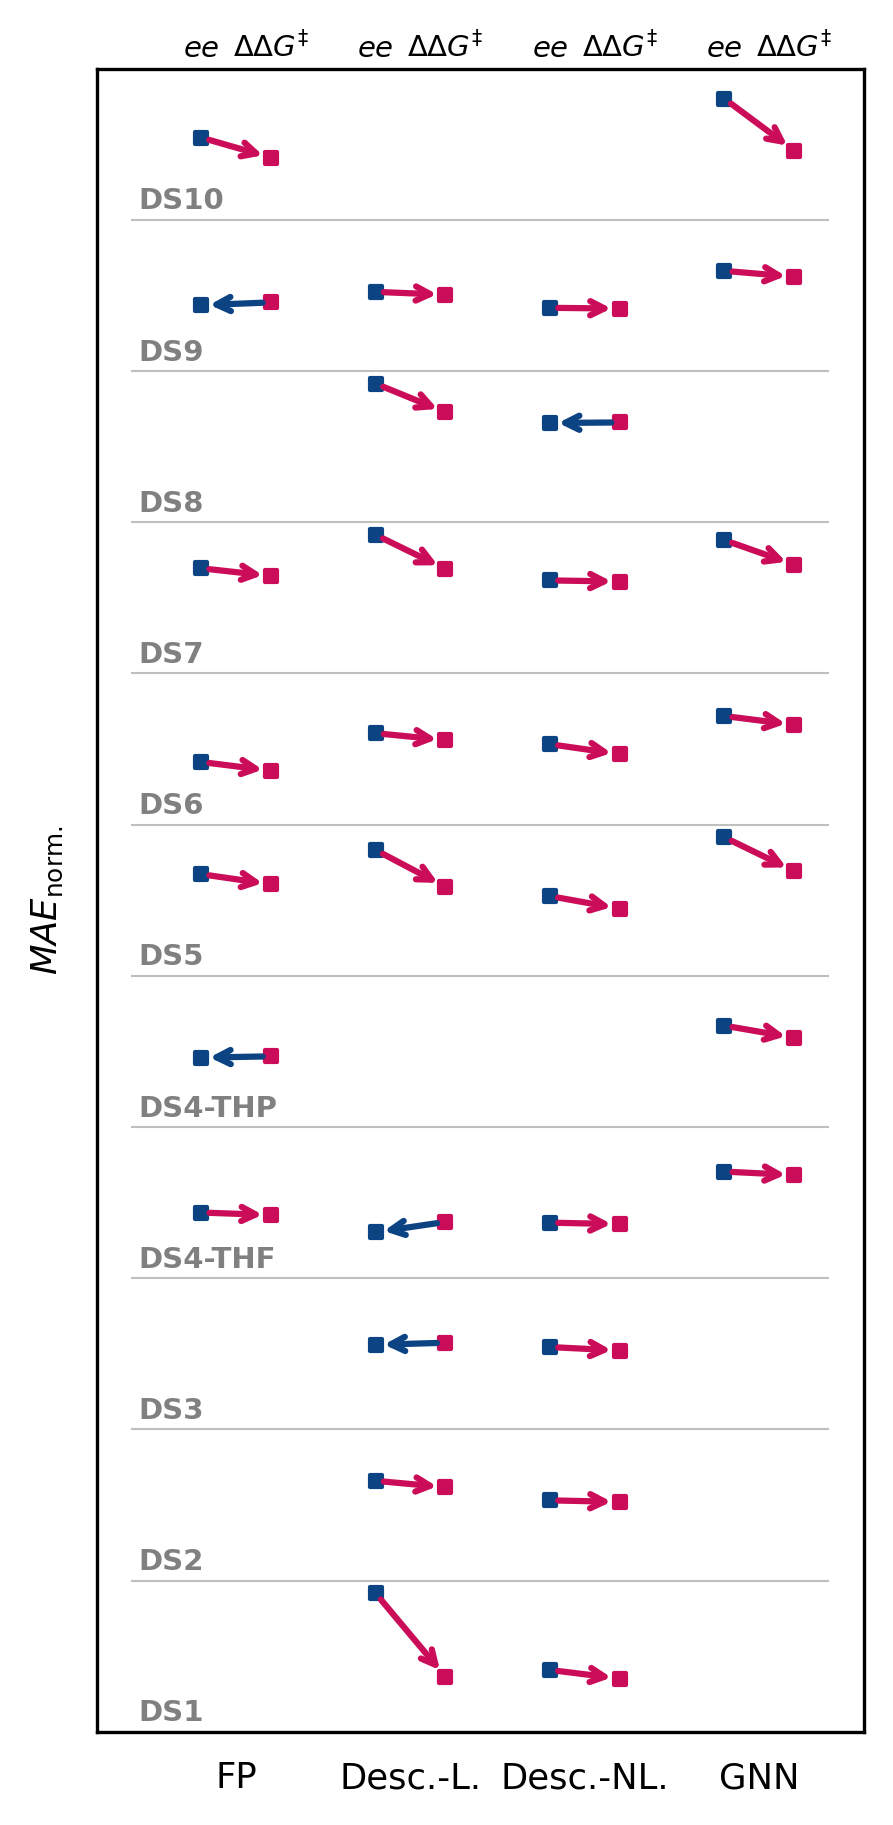

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os
import pandas as pd
fontsize = 8.5
markersize = 8.5
x_offset = 0.24
arrow_width = 1.5
error = 0
extra_y_offset = 0.1
sec_axis_offset = -0.21
text_offset = 0.05
sec_axis_fontsize = 7

plt.figure(figsize=(3.3,12*0.6), dpi=300)

path_files = 'predictions_mr_best'
mode = 'er' # MAE, RMSE, R2, er 

# changed three colors for better visibility
gensch_palette = ['#0C4383',
                '#22A0B6',
                '#46E0A6',
                '#7B1346',
                '#CB0C59']

plt.style.use('default')
plt.rcParams['font.size'] =fontsize

# all possible combinations
dataset_list = ['Denmark_OPRD',
                'Denmark_Science',
                'Doyle_JACS',
                'HongAckermann_NatSyn',
                'List_ACIE_THF',
                'List_ACIE_THP',
                'SigmanBiscoe_Science',
                'SigmanToste_JACS',
                'SigmanToste_Science_Allsamples',
                'Sunoj_JPC',
                'Sunoj_PNAS']

dataset_dict = {
    'Order' : 'Order',
    'SigmanBiscoe_Science' : 'DS1',
    'Doyle_JACS' : 'DS2',
    'SigmanToste_JACS': 'DS3',
    'SigmanToste_Science_Allsamples' : 'DS6',
    'Sunoj_PNAS' : 'DS7',
    'Denmark_Science' : 'DS10',
    'Denmark_OPRD' : 'DS9',
    'Sunoj_JPC': 'DS8',
    'HongAckermann_NatSyn' : 'DS5',
    'List_ACIE_THP' : 'DS4-THP',
    'List_ACIE_THF' : 'DS4-THF',}

modes = ['fp',
         'descriptors',
         'GNN']
targets = ['ee',
           'ddg']
tmodes = ['withT',
          'withoutT']
methods = ['ElasticNetCV',
           'ExtraTreesRegressor',
           'GaussianProcess',
           'GradientBoostingRegressor',
           'KernelRidge_poly',
           'KernelRidge_rbf',
           'KNeighborsRegressor',
           'LassoCV',
           'LinearRegression',
           'RandomForestRegressor',
           'RidgeCV',
           'GNN']
lin_methods = ['ElasticNetCV',
               'LassoCV',
               'LinearRegression',
                'RidgeCV']
nonlin_methods = ['ExtraTreesRegressor',
                    'GaussianProcess',
                    'GradientBoostingRegressor',
                    'KernelRidge_poly',
                    'KernelRidge_rbf',
                    'KNeighborsRegressor',
                    'RandomForestRegressor',
                    'GNN']

best_models = {
    'Order' : ['FP', 'Desc-Lin', 'Desc-Nonlin', 'GNN'],
    'Denmark_Science' : [],
    'Doyle_JACS' : [],
    'HongAckermann_NatSyn' : [],
    'List_ACIE_THF' : [],
    'List_ACIE_THP' : [],
    'SigmanBiscoe_Science' : [],
    'SigmanToste_JACS' : [],
    'SigmanToste_Science_Allsamples' : [],
    'Sunoj_JPC': [],
    'Sunoj_PNAS' : [],
}

#sort dataset by order given in dataset_dict
dataset_list = sorted(dataset_list, key=lambda x: int(dataset_dict[x][:4].replace('DS','').replace('-','')))
print(dataset_list)
def ee2er(ee):
    '''
    ee in %
    '''
    epsilon = 1e-7 #  for numerical stability
    er = (1 + ee/100) / (1 - ee/100 + epsilon)

    return er

def ddg2er(ddg, T):
    '''
    ddg in kcal/mol
    T in Kelvin
    er = exp(-ddg/RT)
    ee = 100 * (er - 1) / (er + 1)
    '''
    # prevent overflow
    if ddg > 10:
        ddg = 10
    T = float(T)
    R_const = 8.31446261815324/1000 # kJ / (mol K)
    ddg *= 4.1839954 # convert from kcal/mol to kJ/mol
    er = np.exp(ddg / (R_const * T))
    return er


def calc_switch(dataframe, T_frame, tc):
    df_switched = pd.DataFrame()
    tc_sw = 'something_wrong_in_switching'
    df_list = []
    dataframe['T'] = T_frame['T']
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: ee2er(row[col]), axis=1)
                tc_sw = 'ddg'
            else:
                df_col = dataframe.apply(lambda row: ddg2er(row[col], row['T']), axis=1)
                tc_sw = 'ee'
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    
    return df_switched

def load_both_datasets_v2(dataset, prediction_dataset):

    # original data
    df_orig = pd.read_csv(f'../datasets/{dataset}.csv')
    df_pred = pd.read_csv(prediction_dataset, delimiter=',')
    df_pred = df_pred.dropna(axis=1, how='any')

    return df_orig, df_pred

def calc_baseline(dataframe, tc):
    mean_val = dataframe[tc].mean()
    diff = dataframe[tc] - mean_val
    mae_baseline = abs(diff).mean()
    rmse_baseline = np.sqrt((diff**2).mean())
    # calc r2 baseline
    r2_baseline = r2_score(dataframe[tc], np.ones(len(dataframe))*mean_val)
    return mae_baseline, rmse_baseline, r2_baseline

def calc_metrics(data_orig, data_pred, only_test = True, baselines = None):
    '''
    baselines = [mae_baseline, rmse_baseline]
    '''
    # only from test set
    maes = []
    rmses = []
    r2s = []
    for col in data_pred.columns:
        if not 'Unnamed' in col and not 'T' in col:
            if only_test:
                train_idx, test_idx = train_test_split(range(len(data_pred)), test_size = 0.2, random_state = int(col))
                data_pred_test = data_pred[col].iloc[test_idx]
                data_orig_test = data_orig.iloc[test_idx]
            else:
                data_pred_test = data_pred[col]
                data_orig_test = data_orig
            mae = mean_absolute_error(data_orig_test, data_pred_test)
            rmse = np.sqrt(mean_squared_error(data_orig_test, data_pred_test))
            r2 = r2_score(data_orig_test, data_pred_test)

            if baselines != None:
                mae = mae / baselines[0]
                rmse = rmse / baselines[1]
                r2 = r2 / (baselines[2] + 1e-7)

            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)

    mae = np.mean(maes)
    rmse = np.mean(rmses)
    r2 = np.mean(r2s)
    return mae, rmse, r2

# list all files in folder
files = os.listdir(f'../{path_files}/')

# first the best models for each dataset have to be found
# rubriks are FP, Desciptors-Lin., Descriptors-Nonlin., GNN


for i, dataset in enumerate(dataset_list):
    metric = 1337
    fp_ee_values = []
    fp_ddg_values = []
    fp_ee_file_list = []
    fp_ddg_file_list = []

    desc_lin_ee_values = []
    desc_lin_ddg_values = []
    desc_lin_ee_file_list = []
    desc_lin_ddg_file_list = []

    desc_nlin_ee_values = []
    desc_nlin_ddg_values = []
    desc_nlin_ee_file_list = []
    desc_nlin_ddg_file_list = []

    gnn_ee_values = []
    gnn_ddg_values = []
    gnn_ee_file_list = []
    gnn_ddg_file_list = []

    for tc in targets:
        for f in files:
            if dataset in f and tc in f:
                prediction_dataset = f'../{path_files}/{f}'
                df_orig, df_preds = load_both_datasets_v2(dataset,
                                        prediction_dataset)
                if mode != 'er':
                    mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, tc)
                    mae, rmse, r2 = calc_metrics(df_orig[tc],
                                                df_preds,
                                                only_test = True,
                                                baselines=[mae_baseline,
                                                            rmse_baseline, 
                                                            r2_baseline])
                else:
                    if tc == 'ee':
                        df_orig[tc] = df_orig[tc].apply(lambda x: ee2er(x))
                    elif tc == 'ddg':
                        df_orig[tc] = df_orig.apply(lambda row: ddg2er(row[tc], row['T']), axis=1)

                    df_preds = calc_switch(df_preds, df_orig, tc)
                    mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, tc)
                    mae, rmse, r2 = calc_metrics(df_orig[tc],
                                                df_preds,
                                                only_test = True,
                                                baselines=[mae_baseline,
                                                            rmse_baseline,
                                                            r2_baseline])
                if mode == 'MAE':
                    metric = mae
                elif mode == 'RMSE':
                    metric = rmse
                elif mode == 'R2':
                    metric = r2
                elif mode == 'er':
                    metric = mae
                if metric < 0:
                    print(f'Metric below 0, something wrong')
                # worse than baseline should not be the best model
                if metric > 1 + error: 
                    print(f'Worse than baseline: {f} with MAE: {mae} and RMSE: {rmse}')
                    metric = 1.0
                print(f'{f} with MAE: {mae} and RMSE: {rmse}')
                if tc == 'ee':
                    if 'fp' in f:
                        fp_ee_values.append(metric)
                        fp_ee_file_list.append(f)
                    elif 'descriptor' in f:
                        # check if one of lin list is in f
                        if any(x in f for x in lin_methods):
                            desc_lin_ee_values.append(metric)
                            desc_lin_ee_file_list.append(f)

                        else:
                            desc_nlin_ee_values.append(metric)
                            desc_nlin_ee_file_list.append(f)
                    elif 'GNN' in f:
                        gnn_ee_values.append(metric)
                        gnn_ee_file_list.append(f)

                elif tc == 'ddg':
                    if 'fp' in f:
                        fp_ddg_values.append(metric)
                        fp_ddg_file_list.append(f)
                    elif 'descriptor' in f:
                        # check if one of lin list is in f
                        if any(x in f for x in lin_methods):
                            desc_lin_ddg_values.append(metric)
                            desc_lin_ddg_file_list.append(f)
                        else:
                            desc_nlin_ddg_values.append(metric)
                            desc_nlin_ddg_file_list.append(f)
                    elif 'GNN' in f:
                        gnn_ddg_values.append(metric)
                        gnn_ddg_file_list.append(f)
         

    # sort files by best for later investigations
    fp_ee_file_list = [x for _,x in sorted(zip(fp_ee_values,fp_ee_file_list))]
    fp_ddg_file_list = [x for _,x in sorted(zip(fp_ddg_values,fp_ddg_file_list))]
    desc_lin_ee_file_list = [x for _,x in sorted(zip(desc_lin_ee_values,desc_lin_ee_file_list))]
    desc_lin_ddg_file_list = [x for _,x in sorted(zip(desc_lin_ddg_values,desc_lin_ddg_file_list))]
    desc_nlin_ee_file_list = [x for _,x in sorted(zip(desc_nlin_ee_values,desc_nlin_ee_file_list))]
    desc_nlin_ddg_file_list = [x for _,x in sorted(zip(desc_nlin_ddg_values,desc_nlin_ddg_file_list))]
    gnn_ee_file_list = [x for _,x in sorted(zip(gnn_ee_values,gnn_ee_file_list))]
    gnn_ddg_file_list = [x for _,x in sorted(zip(gnn_ddg_values,gnn_ddg_file_list))]


    # sometimes any list could be empty because not all datasets have predictions
    # in this case we just add an empty string to the list
    if len(fp_ee_file_list) == 0:
        fp_ee_file_list.append(f'not_trained_for_{dataset}')
    if len(fp_ddg_file_list) == 0:
        fp_ddg_file_list.append(f'not_trained_for_{dataset}')
    if len(desc_lin_ee_file_list) == 0:
        desc_lin_ee_file_list.append(f'not_trained_for_{dataset}')
    if len(desc_lin_ddg_file_list) == 0:
        desc_lin_ddg_file_list.append(f'not_trained_for_{dataset}')
    if len(desc_nlin_ee_file_list) == 0:
        desc_nlin_ee_file_list.append(f'not_trained_for_{dataset}')
    if len(desc_nlin_ddg_file_list) == 0:
        desc_nlin_ddg_file_list.append(f'not_trained_for_{dataset}')
    if len(gnn_ee_file_list) == 0:
        gnn_ee_file_list.append(f'not_trained_for_{dataset}')
    if len(gnn_ddg_file_list) == 0:
        gnn_ddg_file_list.append(f'not_trained_for_{dataset}')

    # also sort the maes and rmses
    fp_ee_values = sorted(fp_ee_values)
    fp_ddg_values = sorted(fp_ddg_values)
    desc_lin_ee_values = sorted(desc_lin_ee_values)
    desc_lin_ddg_values = sorted(desc_lin_ddg_values)
    desc_nlin_ddg_values = sorted(desc_nlin_ddg_values)
    desc_nlin_ee_values = sorted(desc_nlin_ee_values)
    gnn_ee_values = sorted(gnn_ee_values)
    gnn_ddg_values = sorted(gnn_ddg_values)

    # maes will be filled if empty with 1337 so they are outside of plot range
    if len(fp_ee_values) == 0:
        fp_ee_values.append(1337)
    if len(fp_ddg_values) == 0:
        fp_ddg_values.append(1337)
    if len(desc_lin_ee_values) == 0:
        desc_lin_ee_values.append(1337)
    if len(desc_lin_ddg_values) == 0:
        desc_lin_ddg_values.append(1337)
    if len(desc_nlin_ee_values) == 0:
        desc_nlin_ee_values.append(1337)
    if len(desc_nlin_ddg_values) == 0:
        desc_nlin_ddg_values.append(1337)
    if len(gnn_ee_values) == 0:
        gnn_ee_values.append(1337)
    if len(gnn_ddg_values) == 0:
        gnn_ddg_values.append(1337)

    # store in best_models dict
    best_models[dataset] = {'fp_ee': fp_ee_file_list[0],
                            'fp_ddg': fp_ddg_file_list[0],
                            'desc_lin_ee': desc_lin_ee_file_list[0],
                            'desc_lin_ddg': desc_lin_ddg_file_list[0],
                            'desc_nlin_ee': desc_nlin_ee_file_list[0],
                            'desc_nlin_ddg': desc_nlin_ddg_file_list[0],
                            'gnn_ee': gnn_ee_file_list[0],
                            'gnn_ddg': gnn_ddg_file_list[0]}
    
    # its a scatter plot with connecting lines
    # following order fp_ee, fp_ddg, desc_lin_ee, desc_lin_ddg, desc_nlin_ee, desc_nlin_ddg, gnn_ee, gnn_ddg
    # only the best mae is plotted for each method
    # seperated by 1 in each method (fp, etc.) and by 1.5 inter-method
    # the y axis is the MAE or RMSE, depening on the mode chosen
    # for each dataset the y axis is incremented by i, so that the datasets are seperated and stacked on top of each other
    # the x axis is the method, seperated by 1.5
    # the x axis is incremented by j, so that the methods are seperated and stacked on top of each other
    # the color is the target ee or ddg

    plt.scatter([1], [fp_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
    plt.scatter([2], [fp_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
    plt.scatter([3.5], [desc_lin_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
    plt.scatter([4.5], [desc_lin_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
    plt.scatter([6], [desc_nlin_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
    plt.scatter([7], [desc_nlin_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])
    plt.scatter([8.5], [gnn_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[0], s=markersize, marker='s', edgecolors=gensch_palette[0])
    plt.scatter([9.5], [gnn_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset], color=gensch_palette[4], s=markersize, marker='s', edgecolors=gensch_palette[4])

    # print out all the values for the current dataset
    print(f'{dataset}:')
    print(f'fp_ee: {fp_ee_values[0]}')
    print(f'fp_ddg: {fp_ddg_values[0]}')
    print(f'desc_lin_ee: {desc_lin_ee_values[0]}')
    print(f'desc_lin_ddg: {desc_lin_ddg_values[0]}')
    print(f'desc_nlin_ee: {desc_nlin_ee_values[0]}')
    print(f'desc_nlin_ddg: {desc_nlin_ddg_values[0]}')
    print(f'gnn_ee: {gnn_ee_values[0]}')
    print(f'gnn_ddg: {gnn_ddg_values[0]}')
    print('-'*50)
    # now connected by lines with arrow heads
    if fp_ee_values[0] > fp_ddg_values[0]:
        arrow_style = '<-'
        color = gensch_palette[4]
    elif fp_ee_values[0] < fp_ddg_values[0]:
        arrow_style = '->'
        color = gensch_palette[0]
    else:
        arrow_style = '<->'
        color = gensch_palette[2]
    plt.annotate("", xy=(1, fp_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(2, fp_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                lw=arrow_width,
                                                                                                color=color))
    if desc_lin_ee_values[0] > desc_lin_ddg_values[0]:
        arrow_style = '<-'
        color = gensch_palette[4]
    elif desc_lin_ee_values[0] < desc_lin_ddg_values[0]:
        arrow_style = '->'
        color = gensch_palette[0]
    else:
        arrow_style = '<->'
        color = gensch_palette[2]
    plt.annotate("", xy=(3.5, desc_lin_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(4.5, desc_lin_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                                lw=arrow_width,
                                                                                                                color=color))
    if desc_nlin_ee_values[0] > desc_nlin_ddg_values[0]:
        arrow_style = '<-'
        color = gensch_palette[4]
    elif desc_nlin_ee_values[0] < desc_nlin_ddg_values[0]:
        arrow_style = '->'
        color = gensch_palette[0]
    else:
        arrow_style = '<->'
        color = gensch_palette[2]
    plt.annotate("", xy=(6, desc_nlin_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(7, desc_nlin_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                                lw=arrow_width,
                                                                                                                color=color))
    if gnn_ee_values[0] > gnn_ddg_values[0]:
        arrow_style = '<-'
        color = gensch_palette[4]
    elif gnn_ee_values[0] < gnn_ddg_values[0]:
        arrow_style = '->'
        color = gensch_palette[0]
    else:
        arrow_style = '<->'
        color = gensch_palette[2]
    plt.annotate("", xy=(8.5, gnn_ee_values[0] + i + extra_y_offset + i*2*extra_y_offset), xytext=(9.5, gnn_ddg_values[0] + i + extra_y_offset + i*2*extra_y_offset), arrowprops=dict(arrowstyle=arrow_style,
                                                                                                        lw=arrow_width,
                                                                                                        color=color))

    dataset_name = dataset_dict[dataset]
    plt.text(0.1, i + text_offset + extra_y_offset + i*2*extra_y_offset, dataset_name, ha='left', va='center', fontsize=7, color='gray', fontweight='bold')
        
# set custom x ticks and labels occording to the order of the methods
# one label for each method and remove numbers from x axis
plt.xticks([1.5, 4, 6.5, 9], ['FP', 'Desc.-L.', 'Desc.-NL.', 'GNN'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)


hlines_list = [x + 2*extra_y_offset + 2*j*extra_y_offset for j, x in enumerate(np.arange(1, 12))]
print(f'Hlines : {hlines_list}')
# gray horizontal lines each tick of 1 to separate the data sets
plt.hlines(hlines_list, 0, 10, color='gray', lw=0.5, alpha=0.5)
# annotate the hlines with the respective data set

# Set the secondary tick labels
plt.text(1, hlines_list[-1] + 0.1, '$ee$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(2, hlines_list[-1] + 0.1, r'$\Delta\Delta G^‡$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(3.5,hlines_list[-1] + 0.1, '$ee$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(4.5, hlines_list[-1] + 0.1, r'$\Delta\Delta G^‡$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(6, hlines_list[-1] + 0.1, '$ee$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(7, hlines_list[-1] + 0.1, r'$\Delta\Delta G^‡$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(8.5, hlines_list[-1] + 0.1, '$ee$', ha='center', fontsize=sec_axis_fontsize, color='black')
plt.text(9.5, hlines_list[-1] + 0.1, r'$\Delta\Delta G^‡$', ha='center', fontsize=sec_axis_fontsize, color='black')

# remove y ticks
plt.yticks([])
plt.ylim(0, hlines_list[-1])
if mode == 'MAE':
    plt.ylabel(r'MAE$_\mathrm{norm.}$')
elif mode == 'RMSE':
    plt.ylabel(r'RMSE$_\mathrm{norm.}$')
elif mode == 'R2':
    plt.ylabel(r'R$^2$')
elif mode == 'er':
    plt.ylabel(r'$MAE_{\mathrm{norm.}}$')

plt.savefig(f'Fig7.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
best_models

{'Order': ['FP', 'Desc-Lin', 'Desc-Nonlin', 'GNN'],
 'Denmark_Science': {'fp_ee': 'Denmark_Science_KNeighborsRegressor-fp_ee_withoutT.csv',
  'fp_ddg': 'Denmark_Science_RandomForestRegressor_CV_rs-fp_ddg_withoutT.csv',
  'desc_lin_ee': 'not_trained_for_Denmark_Science',
  'desc_lin_ddg': 'not_trained_for_Denmark_Science',
  'desc_nlin_ee': 'not_trained_for_Denmark_Science',
  'desc_nlin_ddg': 'not_trained_for_Denmark_Science',
  'gnn_ee': 'Denmark_Science-GNN_ee_withoutT.csv',
  'gnn_ddg': 'Denmark_Science-GNN_ddg_withT.csv'},
 'Doyle_JACS': {'fp_ee': 'not_trained_for_Doyle_JACS',
  'fp_ddg': 'not_trained_for_Doyle_JACS',
  'desc_lin_ee': 'Doyle_JACS_ElasticNetCV-descriptors_ee_withoutT.csv',
  'desc_lin_ddg': 'Doyle_JACS_LassoCV-descriptors_ddg_withoutT.csv',
  'desc_nlin_ee': 'Doyle_JACS_ExtraTreesRegressor_CV_hrs2-descriptors_ee_withoutT.csv',
  'desc_nlin_ddg': 'Doyle_JACS_ExtraTreesRegressor_CV_hrs2-descriptors_ddg_withoutT.csv',
  'gnn_ee': 'not_trained_for_Doyle_JACS',
  'gnn_dd

# Data export

In [49]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def ee2er(ee):
    epsilon = 1e-7  # for numerical stability
    er = (1 + ee/100) / (1 - ee/100 + epsilon)
    return er

def ddg2er(ddg, T):
    if ddg > 10:
        ddg = 10
    T = float(T)
    R_const = 8.31446261815324/1000  # kJ / (mol K)
    ddg *= 4.1839954  # convert from kcal/mol to kJ/mol
    er = np.exp(ddg / (R_const * T))
    return er

def calc_switch(dataframe, T_frame, tc):
    df_list = []
    dataframe['T'] = T_frame['T']
    for col in dataframe.columns:
        if col != 'T':
            if tc == 'ee':
                df_col = dataframe.apply(lambda row: ee2er(row[col]), axis=1)
            else:
                df_col = dataframe.apply(lambda row: ddg2er(row[col], row['T']), axis=1)
            df_list.append(df_col)
    df_switched = pd.concat(df_list, axis=1)
    dataframe = dataframe.drop(columns=['T'])
    df_switched.columns = dataframe.columns
    return df_switched

def load_both_datasets_v2(dataset, prediction_dataset):
    df_orig = pd.read_csv(f'../code/datasets_230520/{dataset}.csv')
    df_pred = pd.read_csv(prediction_dataset, delimiter=',')
    df_pred = df_pred.dropna(axis=1, how='any')
    return df_orig, df_pred

def calc_baseline(dataframe, tc):
    mean_val = dataframe[tc].mean()
    diff = dataframe[tc] - mean_val
    mae_baseline = abs(diff).mean()
    rmse_baseline = np.sqrt((diff**2).mean())
    r2_baseline = r2_score(dataframe[tc], np.ones(len(dataframe)) * mean_val)
    return mae_baseline, rmse_baseline, r2_baseline

def calc_metrics(data_orig, data_pred, only_test=True, baselines=None):
    maes = []
    rmses = []
    r2s = []
    for col in data_pred.columns:
        if not 'Unnamed' in col and not 'T' in col:
            if only_test:
                train_idx, test_idx = train_test_split(range(len(data_pred)), test_size=0.2, random_state=int(col))
                data_pred_test = data_pred[col].iloc[test_idx]
                data_orig_test = data_orig.iloc[test_idx]
            else:
                data_pred_test = data_pred[col]
                data_orig_test = data_orig
            mae = mean_absolute_error(data_orig_test, data_pred_test)
            rmse = np.sqrt(mean_squared_error(data_orig_test, data_pred_test))
            r2 = r2_score(data_orig_test, data_pred_test)

            if baselines is not None:
                mae = mae / baselines[0]
                rmse = rmse / baselines[1]
                r2 = r2 / (baselines[2] + 1e-7)

            maes.append(mae)
            rmses.append(rmse)
            r2s.append(r2)

    mae = np.mean(maes)
    rmse = np.mean(rmses)
    r2 = np.mean(r2s)
    return mae, rmse, r2

path_files = '../predictions_mr_best'

dataset_dict = {
    'Order': 'Order', 'SigmanBiscoe_Science': 'DS1', 'Doyle_JACS': 'DS2',
    'SigmanToste_JACS': 'DS3', 'SigmanToste_Science_Allsamples': 'DS6', 
    'Sunoj_PNAS': 'DS7', 'Denmark_Science': 'DS10', 'Denmark_OPRD': 'DS9', 
    'Sunoj_JPC': 'DS8', 'HongAckermann_NatSyn': 'DS5', 'List_ACIE_THP': 'DS4-THP',
    'List_ACIE_THF': 'DS4-THF'
}

dataset_list = list(dataset_dict.keys())[1:]  # Exclude 'Order'

methods = ['ElasticNetCV', 'ExtraTreesRegressor', 'GaussianProcess', 'GradientBoostingRegressor', 
           'KernelRidge_poly', 'KernelRidge_rbf', 'KNeighborsRegressor', 'LassoCV', 'LinearRegression', 
           'RandomForestRegressor', 'RidgeCV', 'GNN']

results = []

for dataset in dataset_list:
    for method in methods:
        row = {'Method': method, 'Dataset': dataset_dict[dataset]}
        
        for tc in ['ee', 'ddg']:
            # Create different patterns to match various file naming conventions
            patterns = [
                f"{dataset}_{method}",
                f"{dataset}_{method}_CV",
                f"{dataset}-{method}",
                f"{dataset}_{method.split('_')[0]}",  # For methods like KernelRidge_poly
            ]
            
            matching_files = []
            for pattern in patterns:
                matching_files.extend([f for f in os.listdir(path_files) if pattern in f and tc in f])
            
            if matching_files:
                file_path = os.path.join(path_files, matching_files[0])
                df_orig, df_preds = load_both_datasets_v2(dataset, file_path)
                
                # Convert to er if necessary
                if tc == 'ee':
                    df_orig[tc] = df_orig[tc].apply(lambda x: ee2er(x))
                elif tc == 'ddg':
                    df_orig[tc] = df_orig.apply(lambda row: ddg2er(row[tc], row['T']), axis=1)
                
                df_preds = calc_switch(df_preds, df_orig, tc)
                
                mae_baseline, rmse_baseline, r2_baseline = calc_baseline(df_orig, tc)
                mae, rmse, r2 = calc_metrics(df_orig[tc], df_preds, only_test=True, 
                                             baselines=[mae_baseline, rmse_baseline, r2_baseline])
                
                row[f'MAE_{tc}'] = mae
                row[f'RMSE_{tc}'] = rmse
                row[f'R2_{tc}'] = r2
            else:
                row[f'MAE_{tc}'] = np.nan
                row[f'RMSE_{tc}'] = np.nan
                row[f'R2_{tc}'] = np.nan
        
        results.append(row)

# Create DataFrame from results
df_results = pd.DataFrame(results)

# Sort the DataFrame
df_results['Dataset_order'] = df_results['Dataset'].map({v: k for k, v in enumerate(sorted(set(dataset_dict.values())))})
df_results = df_results.sort_values(['Method', 'Dataset_order']).drop('Dataset_order', axis=1)

# Save to CSV
df_results.to_csv("model_results.csv", index=False)

In [50]:
df_results

,Method,Dataset,MAE_ee,RMSE_ee,R2_ee,MAE_ddg,RMSE_ddg,R2_ddg
0,ElasticNetCV,DS1,2.302721,3.345780,-1.513475e+10,0.461236,0.510183,-1.214845e+07
60,ElasticNetCV,DS10,1.311513,3.537734,-6.236858e+08,0.452406,0.686573,5.009006e+06
12,ElasticNetCV,DS2,0.692039,0.868866,-6.158097e+06,0.666391,0.807976,-3.046387e+06
24,ElasticNetCV,DS3,0.622554,0.702579,3.683051e+06,0.621845,0.679657,3.742082e+06
120,ElasticNetCV,DS4-THF,0.286056,0.348755,7.577950e+06,0.741544,0.916402,-1.915801e+07
...,...,...,...,...,...,...,...,...
106,RidgeCV,DS5,6.451174,23.272492,-2.369616e+11,0.794613,0.991106,-3.517487e+05
46,RidgeCV,DS6,0.563896,0.710402,3.909107e+06,0.571340,0.667557,5.168836e+06
58,RidgeCV,DS7,1.442213,2.213625,-8.029888e+08,0.732661,0.790281,4.355467e+05
94,RidgeCV,DS8,1.772078,6.103311,-6.930962e+09,0.793672,0.901835,1.935311e+06


In [51]:
df_sorted_by_ds = df_results.sort_values(by=['Dataset'])

In [54]:
df_sorted_by_ds = df_sorted_by_ds.round(3)


In [57]:
df_sorted_by_ds = df_sorted_by_ds.drop(columns = ['R2_ee', 'R2_ddg'])

Performance

In [59]:
df_sorted_by_ds.to_csv('all_maes_rmse.csv')
df_sorted_by_ds

,Method,Dataset,MAE_ee,RMSE_ee,MAE_ddg,RMSE_ddg
0,ElasticNetCV,DS1,2.303,3.346,0.461,0.510
6,KNeighborsRegressor,DS1,0.391,0.417,0.391,0.417
2,GaussianProcess,DS1,1.855,2.564,0.322,0.336
11,GNN,DS1,NaN,NaN,NaN,NaN
8,LinearRegression,DS1,3.977,5.886,0.556,0.604
...,...,...,...,...,...,...
83,GNN,DS9,0.695,0.764,0.648,0.706
73,ExtraTreesRegressor,DS9,1.941,1.875,0.447,0.509
72,ElasticNetCV,DS9,0.544,0.602,0.508,0.576
81,RandomForestRegressor,DS9,0.466,0.521,0.424,0.474


In [1]:
import re
from collections import defaultdict

def extract_and_compare(data):
    # Define a regex pattern to capture the categories and their values
    pattern = re.compile(r'(\w+): (\d+\.\d+|\d+)')

    # Default dictionaries to hold sums for ee and ddg
    sums = defaultdict(lambda: {'ee': 0, 'ddg': 0})
    # Find all matches and sum the values
    for match in pattern.finditer(data):
        category, value = match.groups()
        value = float(value)
        if value == 1337:
            continue
        if '_ee' in category:
            main_category = category.replace('_ee', '')
            sums[main_category]['ee'] += value
        elif '_ddg' in category:
            main_category = category.replace('_ddg', '')
            sums[main_category]['ddg'] += value

    # Compare the sums for ee and ddg
    results = {}
    for main_category in sums:
        ee_value = sums[main_category]['ee']
        ddg_value = sums[main_category]['ddg']
        if ee_value < ddg_value:
            performance = ((ee_value - ddg_value) / ddg_value) * 100
            results[main_category] = f"For {main_category.upper()}, the use of ee is {performance:.2f}% better than compared to ddg."
        else:
            performance = ((ddg_value - ee_value) / ee_value) * 100
            results[main_category] = f"For {main_category.upper()}, the use of ddg is {performance:.2f}% better than compared to ee."

    return sums, results




In [2]:
printed_output = """
['SigmanBiscoe_Science', 'Doyle_JACS', 'SigmanToste_JACS', 'List_ACIE_THF', 'List_ACIE_THP', 'HongAckermann_NatSyn', 'SigmanToste_Science', 'Sunoj_PNAS', 'Sunoj_JPC', 'Denmark_OPRD', 'Denmark_Science']
Worse than baseline: SigmanBiscoe_Science_LassoCV-descriptors_ee_withoutT.csv with MAE: 2.2877425010841175 and RMSE: 3.1737101818793936
Worse than baseline: SigmanBiscoe_Science_LinearRegression-descriptors_ee_withoutT.csv with MAE: 3.9774079503615827 and RMSE: 5.886194963422913
Worse than baseline: SigmanBiscoe_Science_GaussianProcess_CV-descriptors_ee_withoutT.csv with MAE: 1.8547450772305707 and RMSE: 2.5636074455641347
Worse than baseline: SigmanBiscoe_Science_ElasticNetCV-descriptors_ee_withoutT.csv with MAE: 2.3027209013338394 and RMSE: 3.345779516005501
Worse than baseline: SigmanBiscoe_Science_RidgeCV-descriptors_ee_withoutT.csv with MAE: 1.5130349724535754 and RMSE: 2.142959152272802
Worse than baseline: SigmanBiscoe_Science_KernelRidge_poly_CV-descriptors_ee_withoutT.csv with MAE: 1.8513294245297813 and RMSE: 2.6671664529416517
SigmanBiscoe_Science:
fp_ee: 1337
fp_ddg: 1337
desc_lin_ee: 1.0
desc_lin_ddg: 0.3388370785497824
desc_nlin_ee: 0.39115219930739115
desc_nlin_ddg: 0.32235175097125146
gnn_ee: 1337
gnn_ddg: 1337
--------------------------------------------------
Worse than baseline: Doyle_JACS_LinearRegression-descriptors_ee_withoutT.csv with MAE: 1.6303399926004145 and RMSE: 2.304479400041086
Worse than baseline: Doyle_JACS_KernelRidge_poly_CV-descriptors_ee_withoutT.csv with MAE: 1.2891812012142816 and RMSE: 2.2245741004445816
Worse than baseline: Doyle_JACS_ExtraTreesRegressor_CV_hrs2-descriptors_ddg_withoutT.csv with MAE: 1.5623729161854067 and RMSE: 1.6809204060366745
Doyle_JACS:
fp_ee: 1337
fp_ddg: 1337
desc_lin_ee: 0.6920387307710587
desc_lin_ddg: 0.6416739111931423
desc_nlin_ee: 0.5371177123983211
desc_nlin_ddg: 0.525093411215894
gnn_ee: 1337
gnn_ddg: 1337
--------------------------------------------------
Worse than baseline: SigmanToste_JACS_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 1.3426894540925653 and RMSE: 1.385787103386494
Worse than baseline: SigmanToste_JACS_LinearRegression-descriptors_ee_withoutT.csv with MAE: 3.660334432905176 and RMSE: 5.148685292481382
Worse than baseline: SigmanToste_JACS_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 219283.25869225446 and RMSE: 431071.1496712328
SigmanToste_JACS:
fp_ee: 1337
fp_ddg: 1337
desc_lin_ee: 0.5716730159073166
desc_lin_ddg: 0.5880849627299309
desc_nlin_ee: 0.5538518537376385
desc_nlin_ddg: 0.5263036320779177
gnn_ee: 1337
gnn_ddg: 1337
--------------------------------------------------
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withoutT.csv with MAE: 1.4226634683645574 and RMSE: 1.4528069298468083
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ee_withT.csv with MAE: 1.537927452408257 and RMSE: 1.5458679211711361
Worse than baseline: List_ACIE_THF_ElasticNetCV-fp_ee_withoutT.csv with MAE: 1.6053741211027037 and RMSE: 2.833699466966006
Worse than baseline: List_ACIE_THF_ElasticNetCV-fp_ee_withT.csv with MAE: 1.3223980940356588 and RMSE: 2.1544394984529633
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ddg_withT.csv with MAE: 1643831.884090923 and RMSE: 2033276.7362129989
Worse than baseline: List_ACIE_THF_LinearRegression-fp_ddg_withoutT.csv with MAE: 1431719.8913421014 and RMSE: 1752916.5924834379
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ddg_withT.csv with MAE: 802317.0172478433 and RMSE: 869914.8488141082
Worse than baseline: List_ACIE_THF_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 520933.5362706396 and RMSE: 690009.5268514908
List_ACIE_THF:
fp_ee: 0.42135716773845344
fp_ddg: 0.40187410276654567
desc_lin_ee: 0.26514068390908446
desc_lin_ddg: 0.3467575133705183
desc_nlin_ee: 0.3408904495885641
desc_nlin_ddg: 0.3296400078338639
gnn_ee: 0.7463905525454473
gnn_ddg: 0.7193244111186677
--------------------------------------------------
Worse than baseline: List_ACIE_THP_LassoCV-fp_ee_withT.csv with MAE: 1.307083073570688 and RMSE: 1.9743148240831787
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ee_withT.csv with MAE: 1.213082054495116 and RMSE: 1.6083543669493088
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ee_withoutT.csv with MAE: 2.7454766722564705 and RMSE: 4.759075891984426
Worse than baseline: List_ACIE_THP_LinearRegression-fp_ddg_withT.csv with MAE: 17400.727480540038 and RMSE: 27343.62225591581
List_ACIE_THP:
fp_ee: 0.4510760886464633
fp_ddg: 0.4610133199964611
desc_lin_ee: 1337
desc_lin_ddg: 1337
desc_nlin_ee: 1337
desc_nlin_ddg: 1337
gnn_ee: 0.7046143950249499
gnn_ddg: 0.608888401323008
--------------------------------------------------
Worse than baseline: HongAckermann_NatSyn_GradientBoostingRegressor_CV_hrs1-descriptors_ee_withT.csv with MAE: 1.5907633870593438 and RMSE: 4.029147508978033
Worse than baseline: HongAckermann_NatSyn_RidgeCV-descriptors_ee_withT.csv with MAE: 6.4511741566630265 and RMSE: 23.272491949275995
Worse than baseline: HongAckermann_NatSyn_KernelRidge_poly_CV-descriptors_ee_withoutT.csv with MAE: 1.0920458826165116 and RMSE: 1.8768681352010919
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-fp_ddg_withT.csv with MAE: 1.264042451448954 and RMSE: 1.4047186496117134
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-descriptors_ddg_withT.csv with MAE: 1.2640386621097246 and RMSE: 1.4047023402785555
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 1.2640396157201814 and RMSE: 1.4047042030763786
Worse than baseline: HongAckermann_NatSyn_GaussianProcess_CV-fp_ee_withoutT.csv with MAE: 1.9269899749251778 and RMSE: 5.403643591979829
Worse than baseline: HongAckermann_NatSyn_RidgeCV-fp_ee_withT.csv with MAE: 1.1238719736094271 and RMSE: 1.9299058777827565
Worse than baseline: HongAckermann_NatSyn_GaussianProcess_CV-descriptors_ee_withT.csv with MAE: 3.687015834235603 and RMSE: 12.444420865093724
Worse than baseline: HongAckermann_NatSyn_LassoCV-fp_ee_withoutT.csv with MAE: 1.4086970207914231 and RMSE: 3.45376867889215
Worse than baseline: HongAckermann_NatSyn_KernelRidge_rbf_CV-descriptors_ee_withT.csv with MAE: 1.2463063376894994 and RMSE: 2.726156252578534
Worse than baseline: HongAckermann_NatSyn_GaussianProcess_CV-fp_ee_withT.csv with MAE: 1.178192303883983 and RMSE: 2.2795763150299875
Worse than baseline: HongAckermann_NatSyn_KernelRidge_rbf_CV-fp_ee_withT.csv with MAE: 1.1120444919153085 and RMSE: 1.879383590004377
Worse than baseline: HongAckermann_NatSyn_KernelRidge_rbf_CV-descriptors_ee_withoutT.csv with MAE: 5.065774024967816 and RMSE: 17.80884589916108
Worse than baseline: HongAckermann_NatSyn-GNN_ee_withoutT.csv with MAE: 1.446563145185325 and RMSE: 2.818472726429786
Worse than baseline: HongAckermann_NatSyn_KernelRidge_poly_CV-fp_ee_withoutT.csv with MAE: 2.8833657485788073 and RMSE: 8.95918211325229
Worse than baseline: HongAckermann_NatSyn_LassoCV-fp_ee_withT.csv with MAE: 1.4086970207914231 and RMSE: 3.45376867889215
Worse than baseline: HongAckermann_NatSyn_GaussianProcess_CV-descriptors_ee_withoutT.csv with MAE: 1.0328509550881666 and RMSE: 1.8472137552929906
Worse than baseline: HongAckermann_NatSyn_ElasticNetCV-descriptors_ee_withT.csv with MAE: 2.0126669245696323 and RMSE: 5.598053420085218
Worse than baseline: HongAckermann_NatSyn_RidgeCV-fp_ee_withoutT.csv with MAE: 1.0400406006529797 and RMSE: 1.5934815501575006
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ee_withT.csv with MAE: 7.6452211155447545 and RMSE: 27.201323464100973
Worse than baseline: HongAckermann_NatSyn_KernelRidge_poly_CV-descriptors_ee_withT.csv with MAE: 1.0522528394474562 and RMSE: 1.756913705652849
Worse than baseline: HongAckermann_NatSyn_KernelRidge_poly_CV-fp_ee_withT.csv with MAE: 1.5079515846724476 and RMSE: 3.4815411691066327
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ee_withoutT.csv with MAE: 2.0083305367058806 and RMSE: 5.062984568056672
Worse than baseline: HongAckermann_NatSyn_ExtraTreesRegressor_CV_rs-fp_ddg_withoutT.csv with MAE: 1.2640393361180822 and RMSE: 1.4047154118952454
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ee_withT.csv with MAE: 1.4647688142146729 and RMSE: 2.8572744997381356
Worse than baseline: HongAckermann_NatSyn-GNN_ee_withT.csv with MAE: 1.2587016992428313 and RMSE: 2.0430854244204966
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ee_withoutT.csv with MAE: 2.4159636290946342 and RMSE: 3.836950842471477
Worse than baseline: HongAckermann_NatSyn_RidgeCV-descriptors_ee_withoutT.csv with MAE: 3.117402067955473 and RMSE: 9.989453179973957
Worse than baseline: HongAckermann_NatSyn_ElasticNetCV-descriptors_ee_withoutT.csv with MAE: 2.0168667324923795 and RMSE: 5.612007616529162
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 2165.0333301458654 and RMSE: 5570.55745864654
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ddg_withT.csv with MAE: 7216.8082536286765 and RMSE: 16382.006670556655
Worse than baseline: HongAckermann_NatSyn_LinearRegression-descriptors_ddg_withT.csv with MAE: 3030.6420200876846 and RMSE: 7378.796588947195
Worse than baseline: HongAckermann_NatSyn_LinearRegression-fp_ddg_withoutT.csv with MAE: 9020.817315280352 and RMSE: 18488.7321957965
HongAckermann_NatSyn:
fp_ee: 0.7067168326961644
fp_ddg: 0.6263398303218355
desc_lin_ee: 0.89898728059089
desc_lin_ddg: 0.60666324833412
desc_nlin_ee: 0.5327269458774849
desc_nlin_ddg: 0.4328488033784654
gnn_ee: 1.0
gnn_ddg: 0.7308842754082141
--------------------------------------------------
Worse than baseline: SigmanToste_Science_Allsamples_ExtraTreesRegressor_CV_rs-fp_ddg_withoutT.csv with MAE: 1.174204157655869 and RMSE: 1.2854558490876185
Worse than baseline: SigmanToste_Science_Allsamples_KernelRidge_poly_CV-fp_ee_withoutT.csv with MAE: 2.271285763351524 and RMSE: 7.158430191341399
Worse than baseline: SigmanToste_Science_Allsamples_LinearRegression-fp_ee_withoutT.csv with MAE: 1.2926569114749256 and RMSE: 2.8541526847448453
Worse than baseline: SigmanToste_Science_Allsamples_KernelRidge_rbf_CV-fp_ee_withoutT.csv with MAE: 1.0255613437796798 and RMSE: 2.661729264573392
SigmanToste_Science:
fp_ee: 0.39713551572085476
fp_ddg: 0.32831153999771295
desc_lin_ee: 1337
desc_lin_ddg: 1337
desc_nlin_ee: 1337
desc_nlin_ddg: 1337
gnn_ee: 0.7620017427698534
gnn_ddg: 0.6923448779615877
--------------------------------------------------
Worse than baseline: Sunoj_PNAS_GaussianProcess_CV-descriptors_ee_withT.csv with MAE: 1.265088913116805 and RMSE: 2.0616132428507394
Worse than baseline: Sunoj_PNAS_GaussianProcess_CV-descriptors_ee_withoutT.csv with MAE: 1.2055615143564808 and RMSE: 1.7387993238567896
Worse than baseline: Sunoj_PNAS_LassoCV-descriptors_ee_withT.csv with MAE: 1.5376793660439714 and RMSE: 2.398782742136014
Worse than baseline: Sunoj_PNAS_KernelRidge_poly_CV-descriptors_ee_withT.csv with MAE: 1.5966391330605065 and RMSE: 2.8840366991090334
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ee_withT.csv with MAE: 2.104148613609791 and RMSE: 4.2543491680127605
Worse than baseline: Sunoj_PNAS_GradientBoostingRegressor_CV_hrs1-descriptors_ee_withoutT.csv with MAE: 1.0978365592671573 and RMSE: 1.7914706340431186
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-descriptors_ee_withT.csv with MAE: 1.3829187475545424 and RMSE: 2.034749095511697
Worse than baseline: Sunoj_PNAS_GradientBoostingRegressor_CV_hrs1-fp_ee_withoutT.csv with MAE: 1.5150808131670492 and RMSE: 2.2445906585798743
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_hrs2-fp_ddg_withT.csv with MAE: 1.0263244549517347 and RMSE: 0.9335162685936926
Worse than baseline: Sunoj_PNAS_RidgeCV-descriptors_ee_withT.csv with MAE: 1.442212772432242 and RMSE: 2.213625387062658
Worse than baseline: Sunoj_PNAS_RidgeCV-descriptors_ee_withoutT.csv with MAE: 1.4231046871124522 and RMSE: 2.186186703625344
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ee_withoutT.csv with MAE: 1.9051023740425992 and RMSE: 3.375983378953271
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ee_withoutT.csv with MAE: 1.6047234951063305 and RMSE: 2.2719297698810674
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_rs-descriptors_ddg_withT.csv with MAE: 1.026318246964609 and RMSE: 0.9335125304880296
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-fp_ee_withT.csv with MAE: 2.0020563355267447 and RMSE: 4.097886334744009
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 1.0263164376417784 and RMSE: 0.933511501962801
Worse than baseline: Sunoj_PNAS_ElasticNetCV-descriptors_ee_withT.csv with MAE: 1.3903509152933244 and RMSE: 1.9576797436622986
Worse than baseline: Sunoj_PNAS_GradientBoostingRegressor_CV_hrs1-fp_ee_withT.csv with MAE: 1.7700768079970566 and RMSE: 2.8849403161935374
Worse than baseline: Sunoj_PNAS_ExtraTreesRegressor_CV_hrs2-fp_ddg_withoutT.csv with MAE: 1.026324582545933 and RMSE: 0.9335160922145992
Worse than baseline: Sunoj_PNAS_GradientBoostingRegressor_CV_hrs1-descriptors_ee_withT.csv with MAE: 1.243520102559685 and RMSE: 2.161479073640055
Worse than baseline: Sunoj_PNAS_LassoCV-descriptors_ee_withoutT.csv with MAE: 1.3721218169682643 and RMSE: 1.9639415098168007
Worse than baseline: Sunoj_PNAS_ElasticNetCV-descriptors_ee_withoutT.csv with MAE: 52.39447968143686 and RMSE: 197.70302498844237
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-fp_ee_withoutT.csv with MAE: 2.197252715223732 and RMSE: 4.812799531319386
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ee_withT.csv with MAE: 3.2825714630138525 and RMSE: 8.752319210516713
Worse than baseline: Sunoj_PNAS_KernelRidge_poly_CV-descriptors_ee_withoutT.csv with MAE: 1.813018666188651 and RMSE: 3.668428520246871
Worse than baseline: Sunoj_PNAS_KernelRidge_rbf_CV-descriptors_ee_withoutT.csv with MAE: 1.5285192788510122 and RMSE: 2.4790710108404057
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ddg_withoutT.csv with MAE: 65059.48515208551 and RMSE: 98215.52514211986
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ddg_withT.csv with MAE: 12052.073650302214 and RMSE: 22067.892300633328
Worse than baseline: Sunoj_PNAS_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 9475.880131881107 and RMSE: 20840.47031773313
Worse than baseline: Sunoj_PNAS_LinearRegression-fp_ddg_withT.csv with MAE: 61647.0968726307 and RMSE: 95523.68287871737
Sunoj_PNAS:
fp_ee: 0.7346785966734847
fp_ddg: 0.6730418336314307
desc_lin_ee: 1.0
desc_lin_ddg: 0.7292959967112563
desc_nlin_ee: 0.6382117052007057
desc_nlin_ddg: 0.6294522631896194
gnn_ee: 0.9584183066220009
gnn_ddg: 0.7633231110273062
--------------------------------------------------
Worse than baseline: Sunoj_JPC_KernelRidge_poly_CV-descriptors_ee_withoutT.csv with MAE: 1.189279480481079 and RMSE: 3.2682828013593586
Worse than baseline: Sunoj_JPC_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 1.5510879736426304 and RMSE: 1.5269095668382868
Worse than baseline: Sunoj_JPC_ElasticNetCV-descriptors_ee_withoutT.csv with MAE: 1.2608839024569862 and RMSE: 2.6679447351428904
Worse than baseline: Sunoj_JPC_RidgeCV-descriptors_ee_withoutT.csv with MAE: 1.7720780805032432 and RMSE: 6.1033114478846064
Worse than baseline: Sunoj_JPC_GaussianProcess_CV-descriptors_ee_withoutT.csv with MAE: 1.3516702900172857 and RMSE: 3.3162043339639076
Worse than baseline: Sunoj_JPC_KernelRidge_rbf_CV-descriptors_ee_withoutT.csv with MAE: 1.8673565977185063 and RMSE: 5.767545919061806
Worse than baseline: Sunoj_JPC_LinearRegression-descriptors_ee_withoutT.csv with MAE: 3.9746002487532297 and RMSE: 14.341212950960509
Worse than baseline: Sunoj_JPC_LassoCV-descriptors_ee_withoutT.csv with MAE: 2.0385670732161962 and RMSE: 7.68767502937089
Worse than baseline: Sunoj_JPC_GradientBoostingRegressor_CV_hrs1-descriptors_ee_withoutT.csv with MAE: 1.6557930533665273 and RMSE: 4.351154626436709
Worse than baseline: Sunoj_JPC_KernelRidge_poly_CV-descriptors_ddg_withoutT.csv with MAE: 1.763679817460515 and RMSE: 7.489909270708897
Worse than baseline: Sunoj_JPC_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 35711.58580999099 and RMSE: 134560.83179602263
Sunoj_JPC:
fp_ee: 1337
fp_ddg: 1337
desc_lin_ee: 1.0
desc_lin_ddg: 0.7737021537710098
desc_nlin_ee: 0.6877020835913978
desc_nlin_ddg: 0.6919424357135913
gnn_ee: 1337
gnn_ddg: 1337
--------------------------------------------------
Worse than baseline: Denmark_OPRD_LinearRegression-descriptors_ee_withoutT.csv with MAE: 6.432507723090868 and RMSE: 25.170515494867626
Worse than baseline: Denmark_OPRD_ExtraTreesRegressor_CV_rs-fp_ddg_withoutT.csv with MAE: 1.9410004136749217 and RMSE: 1.875246900110387
Worse than baseline: Denmark_OPRD_ExtraTreesRegressor_CV_rs-descriptors_ddg_withoutT.csv with MAE: 1.9411509345384883 and RMSE: 1.8752871503184678
Worse than baseline: Denmark_OPRD_LinearRegression-descriptors_ddg_withoutT.csv with MAE: 9486266.643425029 and RMSE: 16872060.450631097
Worse than baseline: Denmark_OPRD_LinearRegression-fp_ddg_withoutT.csv with MAE: 2788334.1860759985 and RMSE: 8956950.910518141
Denmark_OPRD:
fp_ee: 0.42266891001876983
fp_ddg: 0.44462575364275886
desc_lin_ee: 0.5282321757577971
desc_lin_ddg: 0.5058534770098939
desc_nlin_ee: 0.4017623889401547
desc_nlin_ddg: 0.3957395947386605
gnn_ee: 0.6947924674029855
gnn_ddg: 0.6484905107475818
--------------------------------------------------
Worse than baseline: Denmark_Science_KernelRidge_rbf_CV-fp_ee_withoutT.csv with MAE: 1.1230370573783792 and RMSE: 3.8162632210971195
Worse than baseline: Denmark_Science_ElasticNetCV-fp_ee_withoutT.csv with MAE: 1.311513031165457 and RMSE: 3.5377338711283772
Worse than baseline: Denmark_Science_LassoCV-fp_ee_withoutT.csv with MAE: 1.2681872499582831 and RMSE: 3.2647993566800015
Worse than baseline: Denmark_Science_LinearRegression-fp_ee_withoutT.csv with MAE: 5.110259261336965 and RMSE: 26.609782855656558
Worse than baseline: Denmark_Science_RidgeCV-fp_ee_withoutT.csv with MAE: 1.247187162542763 and RMSE: 2.8428168480037885
Worse than baseline: Denmark_Science-GNN_ee_withT.csv with MAE: 1.034901239861671 and RMSE: 3.2980619403177402
Worse than baseline: Denmark_Science_KernelRidge_poly_CV-fp_ee_withoutT.csv with MAE: 3.7299544223172045 and RMSE: 20.022226406530393
Worse than baseline: Denmark_Science_GaussianProcess_CV-fp_ee_withoutT.csv with MAE: 3.213287169966352 and RMSE: 13.425594554605874
Denmark_Science:
fp_ee: 0.5527676689564345
fp_ddg: 0.3935132436511414
desc_lin_ee: 1337
desc_lin_ddg: 1337
desc_nlin_ee: 1337
desc_nlin_ddg: 1337
gnn_ee: 0.8617690406585057
gnn_ddg: 0.449901698344583
--------------------------------------------------
Hlines : [1.2, 2.4000000000000004, 3.6, 4.800000000000001, 6.0, 7.2, 8.4, 9.6, 10.799999999999999, 12.0, 13.2]
"""


In [3]:
sums, results = extract_and_compare(printed_output)
print('Sums:', sums)
print('Results:', results)

Sums: defaultdict(<function extract_and_compare.<locals>.<lambda> at 0x1081a5000>, {'desc_lin': {'ee': 5.956071886936147, 'ddg': 4.530868341669653}, 'desc_nlin': {'ee': 4.083415338641657, 'ddg': 3.853371899119264}, 'fp': {'ee': 3.686400780450625, 'ddg': 3.3287196240078862}, 'gnn': {'ee': 5.727986505023742, 'ddg': 4.613157285930948}})
Results: {'desc_lin': 'For DESC_LIN, the use of ddg is -23.93% better than compared to ee.', 'desc_nlin': 'For DESC_NLIN, the use of ddg is -5.63% better than compared to ee.', 'fp': 'For FP, the use of ddg is -9.70% better than compared to ee.', 'gnn': 'For GNN, the use of ddg is -19.46% better than compared to ee.'}


In [4]:
import re
from collections import defaultdict

def extract_differences(data):
    data_list = data.split('--------------------------------------------------')
    diff_dic = {'ee': [], 'ddg': []}
    # Define a regex pattern to capture the categories and their values
    for i in range(len(data_list)):
        current_data = data_list[i]

        pattern = re.compile(r'(\w+): (\d+\.\d+|\d+)')
        # Find all matches and sum the values
        ee_sum = 0
        ddg_sum = 0
        for match in pattern.finditer(current_data):
            category, value = match.groups()
            value = float(value)
            if value == 1337:
                continue
            if '_ee' in category:
                ee_sum += value
            elif '_ddg' in category:
                ddg_sum += value
        
        # all summed up
        diff_dic['ee'].append(ee_sum)
        diff_dic['ddg'].append(ddg_sum)

    return diff_dic

diff_dic = extract_differences(printed_output)


In [5]:
diff_dic

{'ee': [1.3911521993073912,
  1.2291564431693798,
  1.1255248696449551,
  1.7737788537815493,
  1.1556904836714132,
  3.1384310591645392,
  1.1591372584907083,
  3.331308608496191,
  1.6877020835913978,
  2.047455942119707,
  1.4145367096149402,
  0],
 'ddg': [0.6611888295210339,
  1.1667673224090365,
  1.1143885948078487,
  1.7975960350895956,
  1.0699017213194693,
  2.396736157442635,
  1.0206564179593007,
  2.7951132045596125,
  1.465644589484601,
  1.9947093361388952,
  0.8434149419957244,
  0]}

In [6]:
data = {
    "DS1": {"ee": -0.81, "ΔΔG‡": 0.22, "|skew (ΔΔG‡)|": 0.29, "–|skew (ee)|": 0.16, "N": 24, "skew": -0.52, "KS": 0.16},
    "DS2": {"ee": 0.03, "ΔΔG‡": 0.19, "|skew (ΔΔG‡)|": 0.31, "–|skew (ee)|": 0.22, "N": 29, "skew": 0.28, "KS": 0.22},
    "DS3": {"ee": -0.15, "ΔΔG‡": 0.11, "|skew (ΔΔG‡)|": 0.40, "–|skew (ee)|": 0.11, "N": 37, "skew": 0.25, "KS": 0.11},
    "DS4-THF": {"ee": 0.18, "ΔΔG‡": 0.12, "|skew (ΔΔG‡)|": 0.78, "–|skew (ee)|": 0.12, "N": 80, "skew": 0.60, "KS": 0.12},
    "DS4-THP": {"ee": 0.18, "ΔΔG‡": 0.12, "|skew (ΔΔG‡)|": 0.78, "–|skew (ee)|": 0.12, "N": 80, "skew": 0.60, "KS": 0.12},
    "DS5": {"ee": -1.49, "ΔΔG‡": 0.29, "|skew (ΔΔG‡)|": -0.54, "–|skew (ee)|": 0.17, "N": 127, "skew": -0.95, "KS": 0.17},
    "DS6": {"ee": -0.46, "ΔΔG‡": 0.08, "|skew (ΔΔG‡)|": 0.39, "–|skew (ee)|": 0.07, "N": 159, "skew": -0.07, "KS": 0.07},
    "DS7": {"ee": -3.24, "ΔΔG‡": 0.23, "|skew (ΔΔG‡)|": -0.04, "–|skew (ee)|": 0.05, "N": 371, "skew": -3.20, "KS": 0.05},
    "DS8": {"ee": -3.54, "ΔΔG‡": 0.22, "|skew (ΔΔG‡)|": -0.39, "–|skew (ee)|": 0.09, "N": 398, "skew": -3.15, "KS": 0.09},
    "DS9": {"ee": -1.05, "ΔΔG‡": 0.14, "|skew (ΔΔG‡)|": -0.60, "–|skew (ee)|": 0.09, "N": 471, "skew": -0.45, "KS": 0.09},
    "DS10": {"ee": -0.54, "ΔΔG‡": 0.17, "|skew (ΔΔG‡)|": 0.86, "–|skew (ee)|": 0.08, "N": 1075, "skew": 0.32, "KS": 0.08},
    "AVG": {"ee": -0.11, "ΔΔG‡": 0.18, "|skew (ΔΔG‡)|": 0.15, "–|skew (ee)|": 0.12, "N": 277, "skew": -0.69, "KS": 0.12}
}


In [9]:
import numpy as np
diffs = []
for ddg, ee in zip( diff_dic['ddg'], diff_dic['ee']):
    diff = np.abs(ddg-ee)
    diffs.append(diff)

In [10]:
diffs

[0.7299633697863573,
 0.06238912076034331,
 0.011136274837106441,
 0.02381718130804633,
 0.08578876235194399,
 0.7416949017219041,
 0.13848084053140752,
 0.5361954039365786,
 0.22205749410679676,
 0.05274660598081171,
 0.5711217676192157,
 0]

In [13]:
import pandas as pd

df = pd.DataFrame(data).transpose()

In [14]:
df

,ee,ΔΔG‡,|skew (ΔΔG‡)|,–|skew (ee)|,N,skew,KS
DS1,-0.81,0.22,0.29,0.16,24.0,-0.52,0.16
DS2,0.03,0.19,0.31,0.22,29.0,0.28,0.22
DS3,-0.15,0.11,0.40,0.11,37.0,0.25,0.11
DS4-THF,0.18,0.12,0.78,0.12,80.0,0.60,0.12
DS4-THP,0.18,0.12,0.78,0.12,80.0,0.60,0.12
DS5,-1.49,0.29,-0.54,0.17,127.0,-0.95,0.17
DS6,-0.46,0.08,0.39,0.07,159.0,-0.07,0.07
DS7,-3.24,0.23,-0.04,0.05,371.0,-3.20,0.05
DS8,-3.54,0.22,-0.39,0.09,398.0,-3.15,0.09
DS9,-1.05,0.14,-0.60,0.09,471.0,-0.45,0.09


In [15]:
df['diff'] = diffs

In [16]:
print(df)

           ee  ΔΔG‡  |skew (ΔΔG‡)|  –|skew (ee)|       N  skew    KS      diff
DS1     -0.81  0.22           0.29          0.16    24.0 -0.52  0.16  0.729963
DS2      0.03  0.19           0.31          0.22    29.0  0.28  0.22  0.062389
DS3     -0.15  0.11           0.40          0.11    37.0  0.25  0.11  0.011136
DS4-THF  0.18  0.12           0.78          0.12    80.0  0.60  0.12  0.023817
DS4-THP  0.18  0.12           0.78          0.12    80.0  0.60  0.12  0.085789
DS5     -1.49  0.29          -0.54          0.17   127.0 -0.95  0.17  0.741695
DS6     -0.46  0.08           0.39          0.07   159.0 -0.07  0.07  0.138481
DS7     -3.24  0.23          -0.04          0.05   371.0 -3.20  0.05  0.536195
DS8     -3.54  0.22          -0.39          0.09   398.0 -3.15  0.09  0.222057
DS9     -1.05  0.14          -0.60          0.09   471.0 -0.45  0.09  0.052747
DS10    -0.54  0.17           0.86          0.08  1075.0  0.32  0.08  0.571122
AVG     -0.11  0.18           0.15          0.12   2

In [18]:
corrs = df.corr()

In [19]:
print(corrs)

                     ee      ΔΔG‡  |skew (ΔΔG‡)|  –|skew (ee)|         N  \
ee             1.000000 -0.589393       0.638080      0.409017 -0.265454   
ΔΔG‡          -0.589393  1.000000      -0.559293      0.325612  0.076690   
|skew (ΔΔG‡)|  0.638080 -0.559293       1.000000     -0.006947  0.023626   
–|skew (ee)|   0.409017  0.325612      -0.006947      1.000000 -0.526734   
N             -0.265454  0.076690       0.023626     -0.526734  1.000000   
skew           0.963775 -0.599897       0.638241      0.374127 -0.164214   
KS             0.409017  0.325612      -0.006947      1.000000 -0.526734   
diff          -0.422976  0.722705      -0.188946      0.048731  0.251829   

                   skew        KS      diff  
ee             0.963775  0.409017 -0.422976  
ΔΔG‡          -0.599897  0.325612  0.722705  
|skew (ΔΔG‡)|  0.638241 -0.006947 -0.188946  
–|skew (ee)|   0.374127  1.000000  0.048731  
N             -0.164214 -0.526734  0.251829  
skew           1.000000  0.374127 -0.33

<AxesSubplot:>

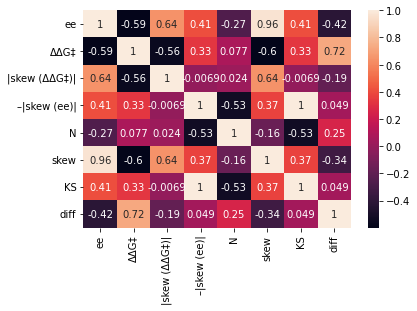

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(corrs, annot=True)

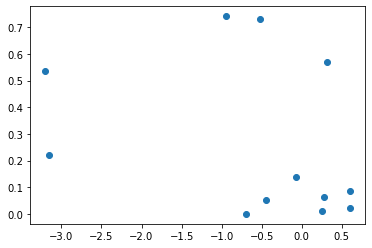

In [24]:
plt.scatter(df['skew'], df['diff'])